<a href="https://colab.research.google.com/github/misko/spf/blob/main/02_beamformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

'''

Given some guess of the source of direction we can shift the carrier frequency
phase of received samples at the N different receivers. If the guess of the
source direction is correct, the signal from the N different receivers should
interfer constructively.

'''

c=3e8 # speed of light

class Source(object):
  def __init__(self,pos):
    self.pos=np.array(pos)

  def signal(self,sampling_times):
    return np.cos(2*np.pi*sampling_times)+np.sin(2*np.pi*sampling_times)*1j

class SinSource(Source):
  def __init__(self,pos,frequency,phase):
    super().__init__(pos)
    self.frequency=frequency
    self.phase=phase

  def signal(self,sampling_times):
    return np.cos(2*np.pi*sampling_times*self.frequency+self.phase)+np.sin(2*np.pi*sampling_times*self.frequency+self.phase)*1j

class Receiver:
  def __init__(self,pos):
    self.pos=np.array(pos)

class Detector(object):
  def __init__(self,sampling_frequency):
    self.sources=[]
    self.receivers=[]
    self.sampling_frequency=sampling_frequency

  def add_source(self,source):
    self.sources.append(source)

  def add_receiver(self,receiver):
    self.receivers.append(receiver)

  def get_signal_matrix(self,start_time,duration):
    n_samples=int(duration*self.sampling_frequency)
    base_times=start_time+np.linspace(0,n_samples-1,n_samples)/self.sampling_frequency
    sample_matrix=np.zeros((len(self.receivers),n_samples),dtype=np.cdouble) # receivers x samples
    for receiver_index,receiver in enumerate(self.receivers):
      for _source in self.sources:
        time_delay=np.linalg.norm(receiver.pos-_source.pos)/c
        sample_matrix[receiver_index,:]+=_source.signal(base_times-time_delay)
    return sample_matrix

  

In [2]:
def beamformer(detector,signal_matrix,carrier_frequency):
  thetas=np.linspace(0,2*np.pi,180)
  steer_dot_signal=np.zeros(thetas.shape[0])
  carrier_wavelength=c/carrier_frequency
  for theta_index,theta in enumerate(thetas):
    source_vector=np.array([np.cos(theta),np.sin(theta)])
    steering_vector=np.zeros(len(detector.receivers)).astype(np.cdouble)
    projections=[]
    for receiver_index,receiver in enumerate(detector.receivers):
      projection_of_receiver_onto_source_direction=np.dot(source_vector,receiver.pos)
      projections.append(projection_of_receiver_onto_source_direction/carrier_wavelength)
      arg=2*np.pi*projection_of_receiver_onto_source_direction/carrier_wavelength
      steering_vector[receiver_index]=np.cos(-arg)+np.sin(-arg)*1j
    steer_dot_signal[theta_index]=np.absolute(np.matmul(steering_vector,signal_matrix)).mean()
  return thetas,steer_dot_signal
  

In [3]:
def plot_space(ax,d):
  #fig,ax=plt.subplots(1,1,figsize=(4,4))
  receiver_pos=np.vstack(
      [ receiver.pos for receiver in d.receivers ]
                )
  _max=receiver_pos.max()
  _min=receiver_pos.min()
  buffer=max(3,int((_max-_min)*0.1))
  _max+=buffer
  _min-=buffer

  center_mass=receiver_pos.mean(axis=0)

  source_vectors=[ (source.pos-center_mass)/np.linalg.norm(source.pos-center_mass) for source in d.sources ]

  ax.set_xlim([_min,_max])
  ax.set_ylim([_min,_max])

  ax.scatter(receiver_pos[:,0],receiver_pos[:,1],label="Receivers")
  for source_vector in source_vectors:
    ax.quiver(center_mass[0], center_mass[1], 
              -source_vector[0], -source_vector[1], scale=5, alpha=0.5,color='red',label="Source")
  ax.legend()


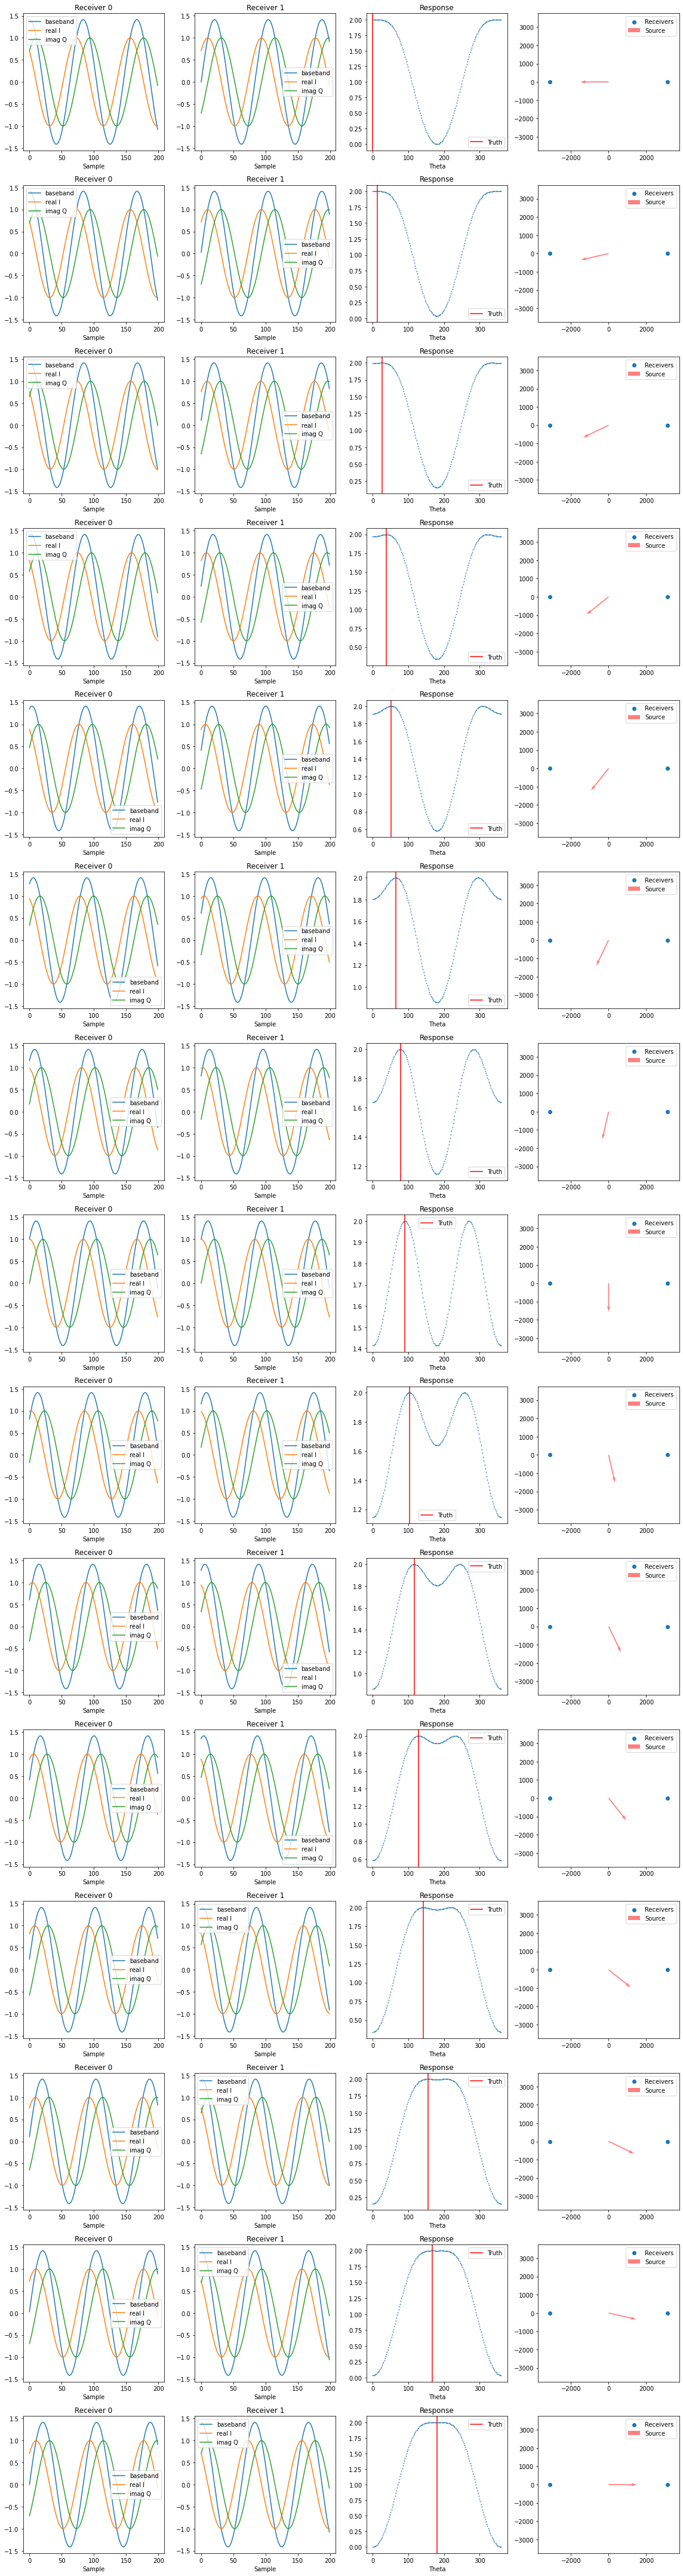

In [5]:

n=15
fig,axs=plt.subplots(n,4,figsize=(4*4,4*n))

for theta_idx,theta in enumerate(np.linspace(0,np.pi,n)):
  d=Detector(1e6) # 1Mhz sampling
  sin_source_frequency=12e3 # 10khz signal 
  wavelength=c/sin_source_frequency

  d.add_source(SinSource([
      wavelength*100000*np.cos(theta),
      wavelength*100000*np.sin(theta)],
      sin_source_frequency,0))
  
  d.add_receiver(Receiver([wavelength/8,0]))
  d.add_receiver(Receiver([-wavelength/8,0]))

  signal_matrix=d.get_signal_matrix(0,200/1e6) 
  n_receivers=len(d.receivers)

  beam_thetas,beam_sds=beamformer(d,signal_matrix,sin_source_frequency)

  for idx in range(signal_matrix.shape[0]):
    axs[theta_idx][idx].plot(signal_matrix[idx].real+signal_matrix[idx].imag,label='baseband')
    axs[theta_idx][idx].plot(signal_matrix[idx].real,label='real I')
    axs[theta_idx][idx].plot(signal_matrix[idx].imag,label='imag Q')
    axs[theta_idx][idx].legend()
    axs[theta_idx][idx].set_title("Receiver %d" % idx)
    axs[theta_idx][idx].set_xlabel("Sample")
  
  beam_degrees=360*beam_thetas/(np.pi*2)
  axs[theta_idx][n_receivers].plot(beam_degrees,beam_sds,alpha=0.1)
  axs[theta_idx][n_receivers].scatter(beam_degrees,beam_sds,s=0.5)
  axs[theta_idx][n_receivers].axvline(x=360*theta/(2*np.pi),label="Truth",color='red')
  axs[theta_idx][n_receivers].set_title("Response")
  axs[theta_idx][n_receivers].set_xlabel("Theta")
  axs[theta_idx][n_receivers].legend()

  plot_space(axs[theta_idx][n_receivers+1],d)
fig.tight_layout()